In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn import model_selection, preprocessing, metrics
plt.style.use('ggplot')

In [2]:
# Read in the dataframes
train_df = pd.read_csv('../input/train.csv')
test_df = pd.read_csv('../input/test.csv')
merch_df = pd.read_csv('../input/merchants.csv')
hist_trans_df = pd.read_csv('../input/historical_transactions.csv')
new_trans_df = pd.read_csv('../input/new_merchant_transactions.csv')
ss_df = pd.read_csv('../input/sample_submission.csv')

In [3]:
# Print data shapes
print('train shape: ', train_df.shape)
print('test shape: ', test_df.shape)
print('merchants shape: ', merch_df.shape)
print('hist_trans shape: ', hist_trans_df.shape)
print('new_trans shape: ', new_trans_df.shape)
print('sample submission shape: ', ss_df.shape)

train shape:  (201917, 6)
test shape:  (123623, 5)
merchants shape:  (334696, 22)
hist_trans shape:  (29112361, 14)
new_trans shape:  (1963031, 14)
sample submission shape:  (123623, 2)


In [4]:
# show some some samples of train data set
train_df.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,target
0,2017-06,C_ID_92a2005557,5,2,1,-0.820283
1,2017-01,C_ID_3d0044924f,4,1,0,0.392913
2,2016-08,C_ID_d639edf6cd,2,2,0,0.688056
3,2017-09,C_ID_186d6a6901,4,3,0,0.142495
4,2017-11,C_ID_cdbd2c0db2,1,3,0,-0.159749


In [5]:
# show dataframe types
train_df.dtypes

first_active_month     object
card_id                object
feature_1               int64
feature_2               int64
feature_3               int64
target                float64
dtype: object

In [6]:
# convert the columns into correct format
train_df['first_active_month'] = pd.to_datetime(train_df['first_active_month'])
train_df['feature_1'] = train_df['feature_1'].astype('category')
train_df['feature_2'] = train_df['feature_2'].astype('category')
train_df['feature_3'] = train_df['feature_3'].astype('category')
train_df.dtypes

first_active_month    datetime64[ns]
card_id                       object
feature_1                   category
feature_2                   category
feature_3                   category
target                       float64
dtype: object

In [7]:
# save and compress into parquet file format
if False:
    train_df.to_parquet('../input/train_df.parquet.gzip',
                        engine='fastparquet',
                        compression='gzip')

In [8]:
# show some some samples of test data set
test_df.head()

,first_active_month,card_id,feature_1,feature_2,feature_3
0,2017-04,C_ID_0ab67a22ab,3,3,1
1,2017-01,C_ID_130fd0cbdd,2,3,0
2,2017-08,C_ID_b709037bc5,5,1,1
3,2017-12,C_ID_d27d835a9f,2,1,0
4,2015-12,C_ID_2b5e3df5c2,5,1,1


In [9]:
# show dataframe types
test_df.dtypes

first_active_month    object
card_id               object
feature_1              int64
feature_2              int64
feature_3              int64
dtype: object

In [10]:
# convert the columns into correct format
test_df['first_active_month'] = pd.to_datetime(test_df['first_active_month'])
test_df['feature_1'] = test_df['feature_1'].astype('category')
test_df['feature_2'] = test_df['feature_2'].astype('category')
test_df['feature_3'] = test_df['feature_3'].astype('category')
test_df.dtypes

first_active_month    datetime64[ns]
card_id                       object
feature_1                   category
feature_2                   category
feature_3                   category
dtype: object

In [11]:
# save and compress into parquet file format
if False:
    test_df.to_parquet('../input/test_df.parquet.gzip',
                       engine='fastparquet',
                       compression='gzip')

In [12]:
# show some some samples of merchant data set
merch_df.head()

,merchant_id,merchant_group_id,merchant_category_id,subsector_id,numerical_1,numerical_2,category_1,most_recent_sales_range,most_recent_purchases_range,avg_sales_lag3,...,avg_sales_lag6,avg_purchases_lag6,active_months_lag6,avg_sales_lag12,avg_purchases_lag12,active_months_lag12,category_4,city_id,state_id,category_2
0,M_ID_838061e48c,8353,792,9,-0.057471,-0.057471,N,E,E,-0.40,...,-2.25,18.666667,6,-2.32,13.916667,12,N,242,9,1.0
1,M_ID_9339d880ad,3184,840,20,-0.057471,-0.057471,N,E,E,-0.72,...,-0.74,1.291667,6,-0.57,1.687500,12,N,22,16,1.0
2,M_ID_e726bbae1e,447,690,1,-0.057471,-0.057471,N,E,E,-82.13,...,-82.13,260.000000,2,-82.13,260.000000,2,N,-1,5,5.0
3,M_ID_a70e9c5f81,5026,792,9,-0.057471,-0.057471,Y,E,E,NaN,...,NaN,4.666667,6,NaN,3.833333,12,Y,-1,-1,NaN
4,M_ID_64456c37ce,2228,222,21,-0.057471,-0.057471,Y,E,E,NaN,...,NaN,0.361111,6,NaN,0.347222,12,Y,-1,-1,NaN


In [13]:
# show dataframe types
merch_df.dtypes

merchant_id                     object
merchant_group_id                int64
merchant_category_id             int64
subsector_id                     int64
numerical_1                    float64
numerical_2                    float64
category_1                      object
most_recent_sales_range         object
most_recent_purchases_range     object
avg_sales_lag3                 float64
avg_purchases_lag3             float64
active_months_lag3               int64
avg_sales_lag6                 float64
avg_purchases_lag6             float64
active_months_lag6               int64
avg_sales_lag12                float64
avg_purchases_lag12            float64
active_months_lag12              int64
category_4                      object
city_id                          int64
state_id                         int64
category_2                     float64
dtype: object

In [14]:
# convert the columns into correct format
merch_df['merchant_group_id'] = merch_df['merchant_group_id'].astype('category')
merch_df['merchant_category_id'] = merch_df['merchant_category_id'].astype('category')
merch_df['subsector_id'] = merch_df['subsector_id'].astype('category')
merch_df['category_1'] = merch_df['category_1'].astype('category')
merch_df['most_recent_sales_range'] = merch_df['most_recent_sales_range'].astype('category')
merch_df['most_recent_purchases_range'] = merch_df['most_recent_purchases_range'].astype('category')
merch_df['category_4'] = merch_df['category_4'].astype('category')
merch_df['city_id'] = merch_df['city_id'].astype('category')
merch_df['state_id'] = merch_df['state_id'].astype('category')
merch_df['category_2'] = merch_df['category_2'].astype('category')
merch_df.dtypes

merchant_id                      object
merchant_group_id              category
merchant_category_id           category
subsector_id                   category
numerical_1                     float64
numerical_2                     float64
category_1                     category
most_recent_sales_range        category
most_recent_purchases_range    category
avg_sales_lag3                  float64
avg_purchases_lag3              float64
active_months_lag3                int64
avg_sales_lag6                  float64
avg_purchases_lag6              float64
active_months_lag6                int64
avg_sales_lag12                 float64
avg_purchases_lag12             float64
active_months_lag12               int64
category_4                     category
city_id                        category
state_id                       category
category_2                     category
dtype: object

In [15]:
# save and compress into parquet file format
if False:
    merch_df.to_parquet('../input/merch_df.parquet.gzip',
                        engine='fastparquet',
                        compression='gzip')

In [16]:
# show some some samples of historical transactions data set
hist_trans_df.head()

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-8,-0.703331,2017-06-25 15:33:07,1.0,16,37
1,Y,C_ID_4e6213e9bc,88,N,0,A,367,M_ID_86ec983688,-7,-0.733128,2017-07-15 12:10:45,1.0,16,16
2,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_979ed661fc,-6,-0.720386,2017-08-09 22:04:29,1.0,16,37
3,Y,C_ID_4e6213e9bc,88,N,0,A,560,M_ID_e6d5ae8ea6,-5,-0.735352,2017-09-02 10:06:26,1.0,16,34
4,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-11,-0.722865,2017-03-10 01:14:19,1.0,16,37


In [17]:
# show dataframe types
hist_trans_df.dtypes

authorized_flag          object
card_id                  object
city_id                   int64
category_1               object
installments              int64
category_3               object
merchant_category_id      int64
merchant_id              object
month_lag                 int64
purchase_amount         float64
purchase_date            object
category_2              float64
state_id                  int64
subsector_id              int64
dtype: object

In [18]:
# convert the columns into correct format
hist_trans_df['authorized_flag'] = hist_trans_df['authorized_flag'].astype('category')
hist_trans_df['city_id'] = hist_trans_df['city_id'].astype('category')
hist_trans_df['category_1'] = hist_trans_df['category_1'].astype('category')
hist_trans_df['category_3'] = hist_trans_df['category_3'].astype('category')
hist_trans_df['merchant_category_id'] = hist_trans_df['merchant_category_id'].astype('category')
hist_trans_df['purchase_date'] = pd.to_datetime(hist_trans_df['purchase_date'])
hist_trans_df['category_2'] = hist_trans_df['category_2'].astype('category')
hist_trans_df['state_id'] = hist_trans_df['state_id'].astype('category')
hist_trans_df['subsector_id'] = hist_trans_df['subsector_id'].astype('category')
hist_trans_df.dtypes

authorized_flag               category
card_id                         object
city_id                       category
category_1                    category
installments                     int64
category_3                    category
merchant_category_id          category
merchant_id                     object
month_lag                        int64
purchase_amount                float64
purchase_date           datetime64[ns]
category_2                    category
state_id                      category
subsector_id                  category
dtype: object

In [19]:
# save and compress into parquet file format
if False:
    hist_trans_df.to_parquet('../input/hist_trans_df.parquet.gzip',
                             engine='fastparquet',
                             compression='gzip')

In [20]:
# show some some samples of new transactions data set
new_trans_df.head()

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,Y,C_ID_415bb3a509,107,N,1,B,307,M_ID_b0c793002c,1,-0.557574,2018-03-11 14:57:36,1.0,9,19
1,Y,C_ID_415bb3a509,140,N,1,B,307,M_ID_88920c89e8,1,-0.569580,2018-03-19 18:53:37,1.0,9,19
2,Y,C_ID_415bb3a509,330,N,1,B,507,M_ID_ad5237ef6b,2,-0.551037,2018-04-26 14:08:44,1.0,9,14
3,Y,C_ID_415bb3a509,-1,Y,1,B,661,M_ID_9e84cda3b1,1,-0.671925,2018-03-07 09:43:21,NaN,-1,8
4,Y,C_ID_ef55cf8d4b,-1,Y,1,B,166,M_ID_3c86fa3831,1,-0.659904,2018-03-22 21:07:53,NaN,-1,29


In [21]:
# show dataframe types
new_trans_df.dtypes

authorized_flag          object
card_id                  object
city_id                   int64
category_1               object
installments              int64
category_3               object
merchant_category_id      int64
merchant_id              object
month_lag                 int64
purchase_amount         float64
purchase_date            object
category_2              float64
state_id                  int64
subsector_id              int64
dtype: object

In [22]:
# convert the columns into correct format
new_trans_df['authorized_flag'] = new_trans_df['authorized_flag'].astype('category')
new_trans_df['city_id'] = new_trans_df['city_id'].astype('category')
new_trans_df['category_1'] = new_trans_df['category_1'].astype('category')
new_trans_df['category_3'] = new_trans_df['category_3'].astype('category')
new_trans_df['merchant_category_id'] = new_trans_df['merchant_category_id'].astype('category')
new_trans_df['purchase_date'] = pd.to_datetime(new_trans_df['purchase_date'])
new_trans_df['category_2'] = new_trans_df['category_2'].astype('category')
new_trans_df['state_id'] = new_trans_df['state_id'].astype('category')
new_trans_df['subsector_id'] = new_trans_df['subsector_id'].astype('category')
new_trans_df.dtypes

authorized_flag               category
card_id                         object
city_id                       category
category_1                    category
installments                     int64
category_3                    category
merchant_category_id          category
merchant_id                     object
month_lag                        int64
purchase_amount                float64
purchase_date           datetime64[ns]
category_2                    category
state_id                      category
subsector_id                  category
dtype: object

In [23]:
# save and compress into parquet file format
if False:
    new_trans_df.to_parquet('../input/new_trans_df.parquet.gzip',
                            engine='fastparquet',
                            compression='gzip')

In [24]:
# show some some samples of sample submission data set
ss_df.head()

,card_id,target
0,C_ID_0ab67a22ab,0
1,C_ID_130fd0cbdd,0
2,C_ID_b709037bc5,0
3,C_ID_d27d835a9f,0
4,C_ID_2b5e3df5c2,0


In [25]:
# show dataframe types
ss_df.dtypes

card_id    object
target      int64
dtype: object

In [26]:
# save and compress into parquet file format
if False:
    ss_df.to_parquet('../input/ss_df.parquet.gzip',
                     engine='fastparquet',
                     compression='gzip')

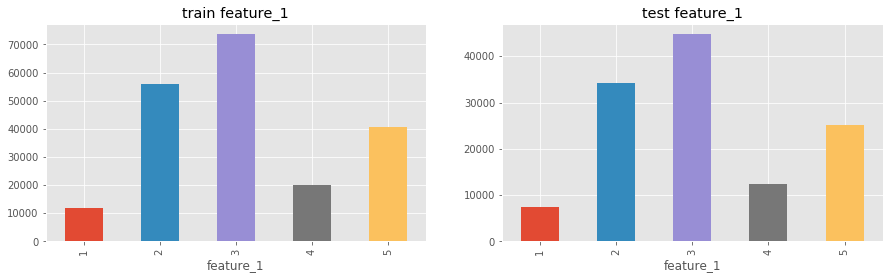

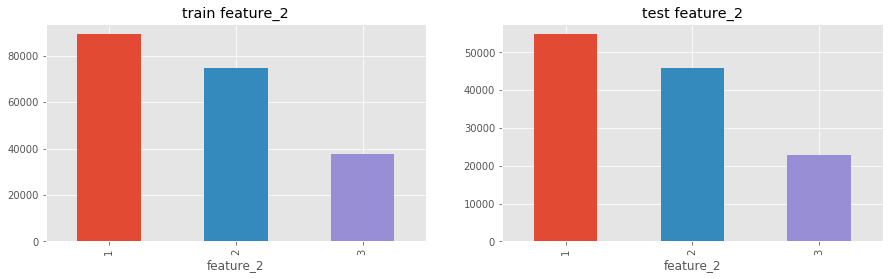

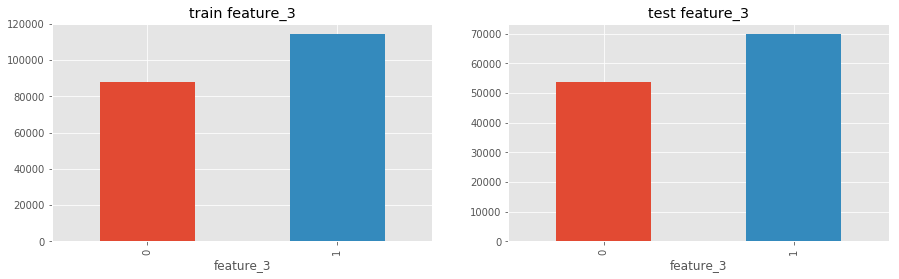

In [27]:
features = ['feature_1', 'feature_2', 'feature_3']
for feature in features:
    fig, axes = plt.subplots(nrows=1, ncols=2)
    train_df.groupby(feature).count()['first_active_month'].plot(kind='bar',
                                                                 title='train {}'.format(feature),
                                                                 figsize=(15, 4),
                                                                 ax=axes[0])
    test_df.groupby(feature).count()['first_active_month'].plot(kind='bar',
                                                                title='test {}'.format(feature),
                                                                figsize=(15, 4))
    plt.show()

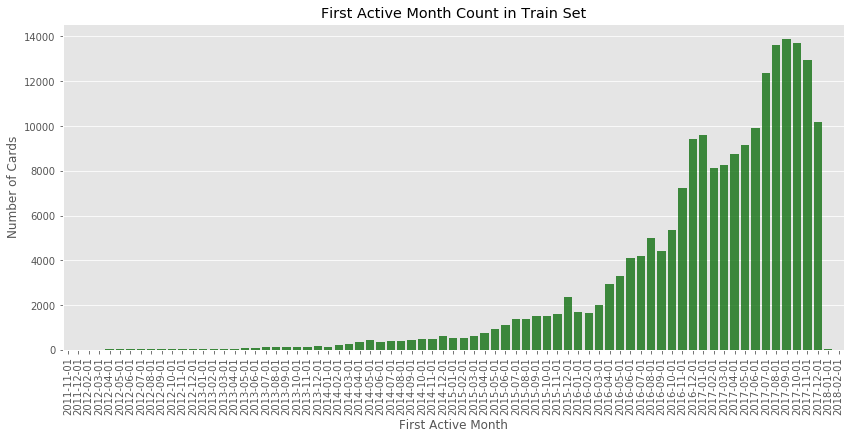

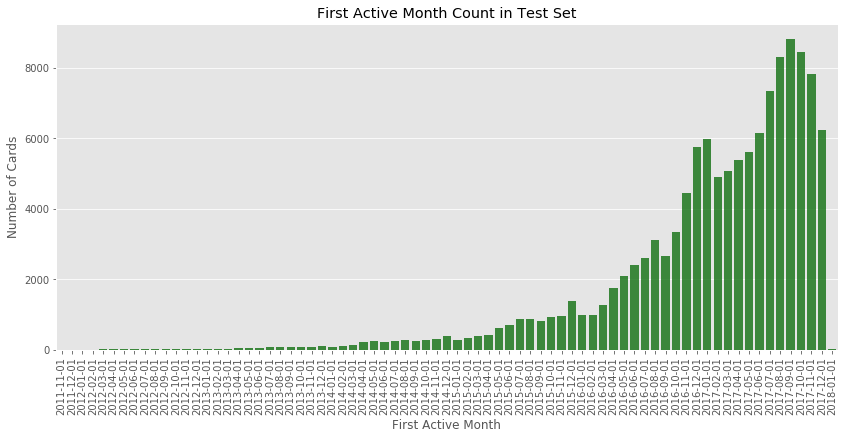

In [28]:
cnt_srs = train_df['first_active_month'].dt.date.value_counts()
cnt_srs = cnt_srs.sort_index()
plt.figure(figsize=(14, 6))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8, color='green')
plt.xticks(rotation='vertical')
plt.xlabel('First Active Month', fontsize=12)
plt.ylabel('Number of Cards', fontsize=12)
plt.title("First Active Month Count in Train Set")
plt.show()

cnt_srs = test_df['first_active_month'].dt.date.value_counts()
cnt_srs = cnt_srs.sort_index()
plt.figure(figsize=(14, 6))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8, color='green')
plt.xticks(rotation='vertical')
plt.xlabel('First Active Month', fontsize=12)
plt.ylabel('Number of Cards', fontsize=12)
plt.title("First Active Month Count in Test Set")
plt.show()

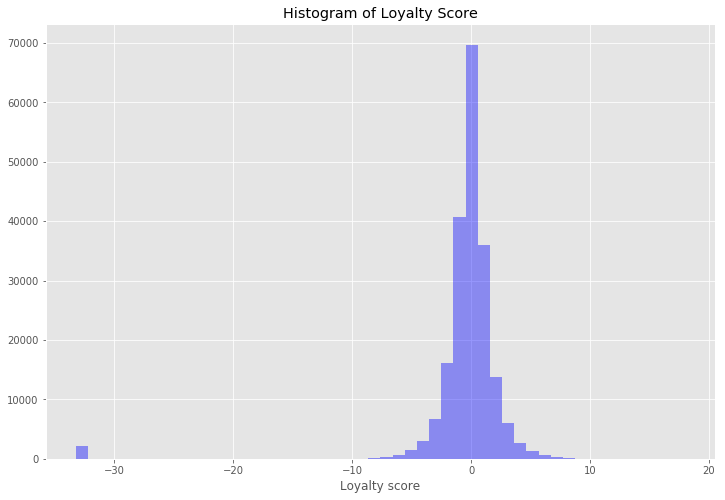

In [29]:
# plot the target distribution
plt.figure(figsize=(12, 8))
sns.distplot(train_df['target'].values, bins=50, kde=False, color='blue')
plt.title('Histogram of Loyalty Score')
plt.xlabel('Loyalty score', fontsize=12)
plt.show()

In [30]:
hist_trans_df.head(5)

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-8,-0.703331,2017-06-25 15:33:07,1.0,16,37
1,Y,C_ID_4e6213e9bc,88,N,0,A,367,M_ID_86ec983688,-7,-0.733128,2017-07-15 12:10:45,1.0,16,16
2,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_979ed661fc,-6,-0.720386,2017-08-09 22:04:29,1.0,16,37
3,Y,C_ID_4e6213e9bc,88,N,0,A,560,M_ID_e6d5ae8ea6,-5,-0.735352,2017-09-02 10:06:26,1.0,16,34
4,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-11,-0.722865,2017-03-10 01:14:19,1.0,16,37


In [31]:
# number of unique card_id in historical transactions
hist_trans_card_id_list = hist_trans_df['card_id'].unique()
len(hist_trans_card_id_list)

325540

In [32]:
# number of unique card_id in new transactions
new_trans_card_id_list = new_trans_df['card_id'].unique()
len(new_trans_card_id_list)

290001

In [33]:
# number of unique card_id in test
test_card_id_list = test_df['card_id'].unique()
len(test_card_id_list)

123623

In [50]:
# number of unique card_id in test
train_card_id_list = train_df['card_id'].unique()
len(train_card_id_list)

201917

In [34]:
# check if new card_id is subset of historical card_id
set(new_trans_card_id_list).issubset(set(hist_trans_card_id_list))

True

In [51]:
# check if train card_id is subset of historical card_id
set(train_card_id_list).issubset(set(hist_trans_card_id_list))

True

In [52]:
# check if train card_id is subset of new card_id
set(train_card_id_list).issubset(set(new_trans_card_id_list))

False

In [53]:
# check the intersection of train and new card_id
len(set(train_card_id_list).intersection(set(new_trans_card_id_list)))

179986

In [35]:
# check if test card_id is subset of historical card_id
set(test_card_id_list).issubset(set(hist_trans_card_id_list))

True

In [36]:
# check if test card_id is subset of new card_id
set(test_card_id_list).issubset(set(new_trans_card_id_list))

False

In [37]:
# check the intersection of test and new card_id
len(set(test_card_id_list).intersection(set(new_trans_card_id_list)))

110015

In [38]:
# number of unique merchant_id in historical transactions
hist_trans_merch_id_list = hist_trans_df['merchant_id'].unique()
len(hist_trans_merch_id_list)

326312

In [39]:
# percent of missing merchant id in historical transactions
len(hist_trans_df[hist_trans_df['merchant_id'].notnull()]) / len(hist_trans_df)

0.995243223316721

In [40]:
# number of unique merchant_id in new transactions
new_trans_merch_id_list = new_trans_df['merchant_id'].unique()
len(new_trans_merch_id_list)

226130

In [41]:
# number of missing merchant id in new transactions
len(new_trans_df[new_trans_df['merchant_id'].notnull()]) / len(new_trans_df)

0.9866451421296963

In [42]:
# check if new merchant_id is subset of historical card_id
set(new_trans_merch_id_list).issubset(set(hist_trans_merch_id_list))

False

In [43]:
# check the intersection of historical and new merchant_id
len(set(new_trans_merch_id_list).intersection(set(hist_trans_merch_id_list)))

217808

In [44]:
# number if unique of mechant_id, has duplicates, 334633 < 334696, with 33 duplicates
merchant_id_list = merch_df['merchant_id'].unique()
len(merchant_id_list)

334633

In [45]:
# check missing values of features:
print('=================hist_trans_df====================')
print('authorized_flag missing #: ', len(hist_trans_df[hist_trans_df['authorized_flag'].isnull()]))
print('installments missing #: ', len(hist_trans_df[hist_trans_df['installments'].isnull()]))
print('category_1 missing #: ', len(hist_trans_df[hist_trans_df['category_1'].isnull()]))
print('category_2 missing #: ', len(hist_trans_df[hist_trans_df['category_2'].isnull()]))
print('category_3 missing #: ', len(hist_trans_df[hist_trans_df['category_3'].isnull()]))
print('subsector_id missing #: ', len(hist_trans_df[hist_trans_df['subsector_id'].isnull()]))
print('merchant_category_id missing #: ', len(hist_trans_df[hist_trans_df['merchant_category_id'].isnull()]))
print('city_id missing #: ', len(hist_trans_df[hist_trans_df['city_id'].isnull()]))
print('state_id missing #: ', len(hist_trans_df[hist_trans_df['state_id'].isnull()]))
print('month_lag missing #: ', len(hist_trans_df[hist_trans_df['month_lag'].isnull()]))
print('=================new_trans_df====================')
print('authorized_flag missing #: ', len(new_trans_df[new_trans_df['authorized_flag'].isnull()]))
print('installments missing #: ', len(new_trans_df[new_trans_df['installments'].isnull()]))
print('category_1 missing #: ', len(new_trans_df[new_trans_df['category_1'].isnull()]))
print('category_2 missing #: ', len(new_trans_df[new_trans_df['category_2'].isnull()]))
print('category_3 missing #: ', len(new_trans_df[new_trans_df['category_3'].isnull()]))
print('subsector_id missing #: ', len(new_trans_df[new_trans_df['subsector_id'].isnull()]))
print('merchant_category_id missing #: ', len(new_trans_df[new_trans_df['merchant_category_id'].isnull()]))
print('city_id missing #: ', len(new_trans_df[new_trans_df['city_id'].isnull()]))
print('state_id missing #: ', len(new_trans_df[new_trans_df['state_id'].isnull()]))
print('month_lag missing #: ', len(new_trans_df[new_trans_df['month_lag'].isnull()]))
print('=================merch_df====================')
print('category_4 missing #: ', len(merch_df[merch_df['category_4'].isnull()]))
print('merchant_group_id missing #: ', len(merch_df[merch_df['merchant_group_id'].isnull()]))

=================hist_trans_df====================
authorized_flag missing #:  0
installments missing #:  0
category_1 missing #:  0
category_2 missing #:  2652864
category_3 missing #:  178159
subsector_id missing #:  0
merchant_category_id missing #:  0
city_id missing #:  0
state_id missing #:  0
month_lag missing #:  0
=================new_trans_df====================
authorized_flag missing #:  0
installments missing #:  0
category_1 missing #:  0
category_2 missing #:  111745
category_3 missing #:  55922
subsector_id missing #:  0
merchant_category_id missing #:  0
city_id missing #:  0
state_id missing #:  0
month_lag missing #:  0
=================merch_df====================
category_4 missing #:  0
merchant_group_id missing #:  0


In [46]:
# fill in some missing values
hist_trans_df['category_2'] = hist_trans_df['category_2'].cat.add_categories(-999).fillna(-999)
hist_trans_df['category_3'] = hist_trans_df['category_3'].cat.add_categories('X').fillna('X')
new_trans_df['category_2'] = new_trans_df['category_2'].cat.add_categories(-999).fillna(-999)
new_trans_df['category_3'] = new_trans_df['category_3'].cat.add_categories('X').fillna('X')

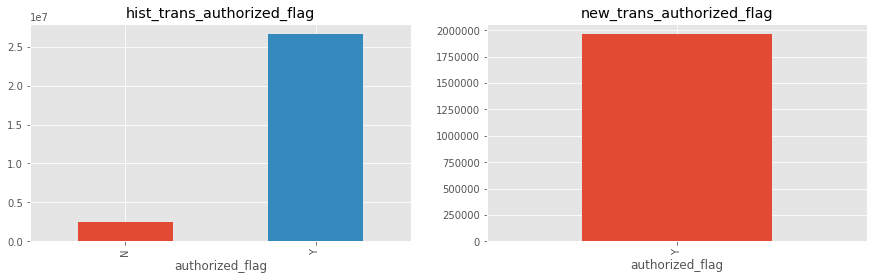

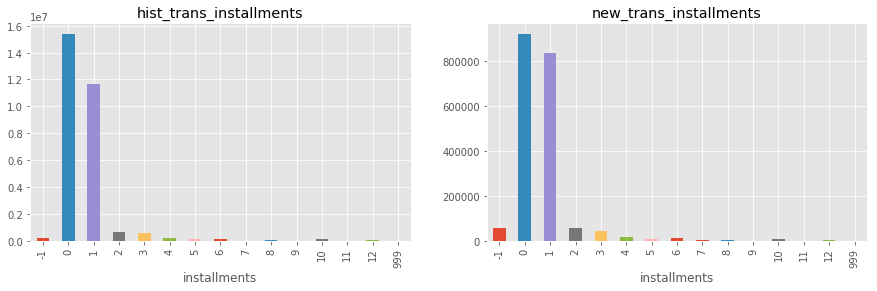

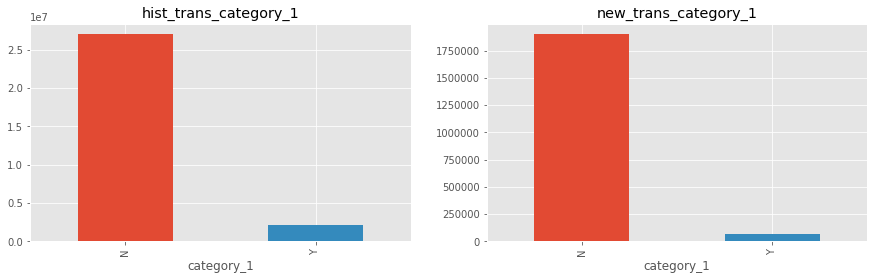

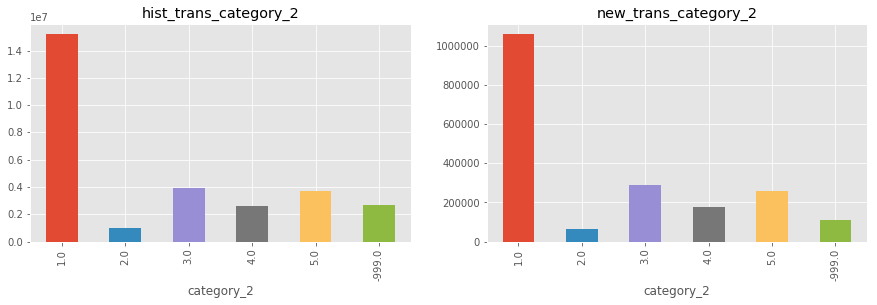

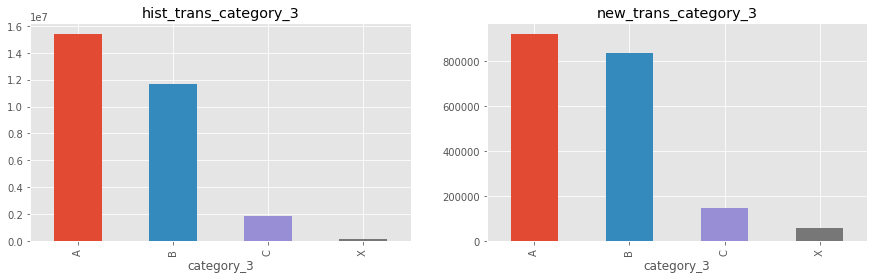

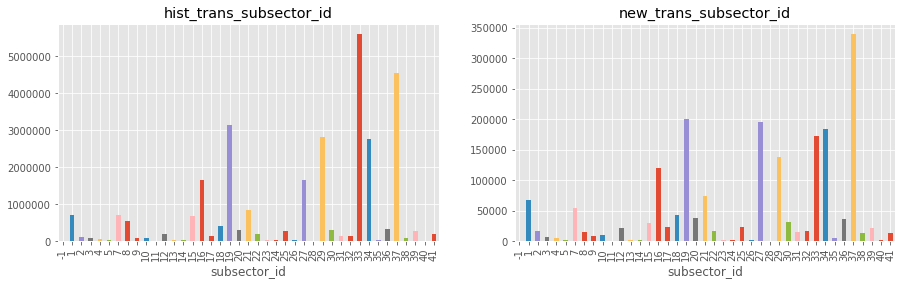

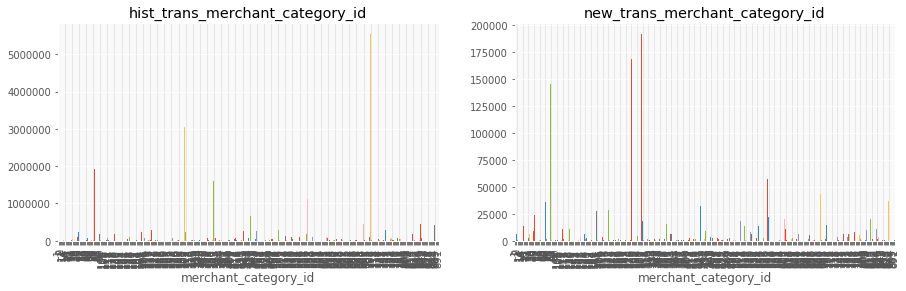

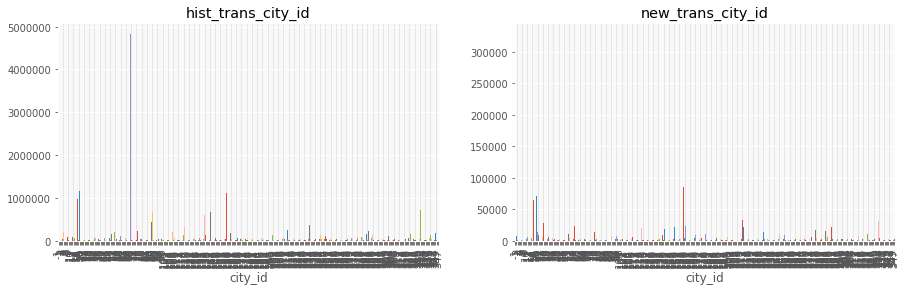

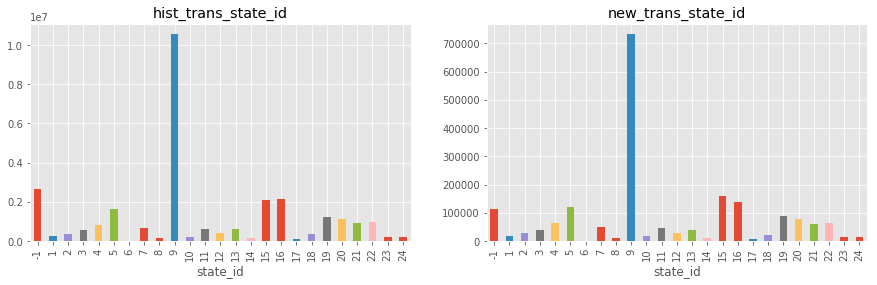

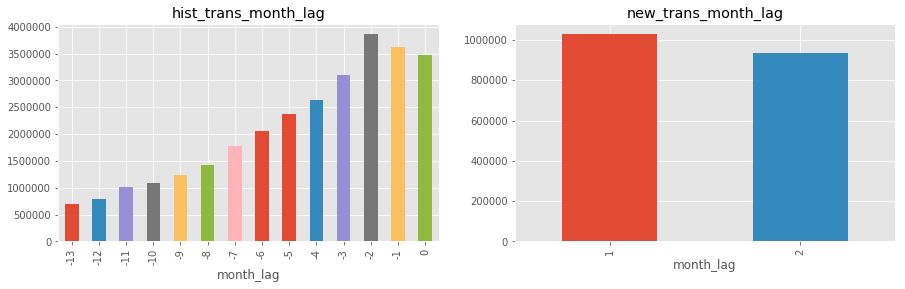

In [47]:
# features distrubution in historical and new transactions
features = ['authorized_flag',
            'installments',
            'category_1',
            'category_2',
            'category_3',
            'subsector_id',
            'merchant_category_id',
            'city_id',
            'state_id',
            'month_lag']
for feature in features:
    fig, axes = plt.subplots(nrows=1, ncols=2)
    hist_trans_df.groupby(feature).count()['card_id'].plot(kind='bar',
                                                           title='hist_trans_{}'.format(feature),
                                                           figsize=(15, 4),
                                                           ax=axes[0])
    new_trans_df.groupby(feature).count()['card_id'].plot(kind='bar',
                                                          title='new_trans_{}'.format(feature),
                                                          figsize=(15, 4))
    plt.show()

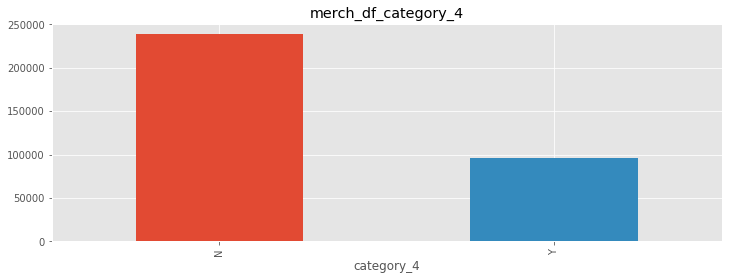

In [48]:
# features distrubution in merchants
features = ['category_4']
for feature in features:
    fig, axes = plt.subplots(nrows=1)
    merch_df.groupby(feature).count()['merchant_id'].plot(kind='bar',
                                                          title='merch_df_{}'.format(feature),
                                                          figsize=(12, 4))
    plt.show()

In [49]:
merch_df.groupby('merchant_group_id')['merchant_id'].count().reset_index(name='count').sort_values(['count'],
                                                                                                   ascending=False).head(20)

,merchant_group_id,count
34,35,46026
430,434,482
416,419,365
703,713,333
3604,3648,305
47,48,283
1127,1145,276
759,771,257
323,325,248
319,321,235
